In [1]:
#
# Working through
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_8_estimability.py
#

In [2]:
# Sample Problem 
# using simulated data for a concentration-only problem for 5 components and
# 4 kinetic parameters this problem demonstrates the estimability parameter ranking
# algorithm

from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.EstimabilityAnalyzer import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [3]:
filename = 'new_estim_problem_conc.csv'
D_frame = read_concentration_data_from_csv(filename, directory = '../data_sets')

read dir : /home/paperspace/learn_kipet/kipet_examples/../data_sets/new_estim_problem_conc.csv


In [4]:
D_frame

,A,B,C,D,E
0.00000,0.296158,0.005100,0.000000,0.012171,0.000846
0.03101,0.292748,0.010935,0.000000,0.010323,0.001318
0.12899,0.254150,0.033794,0.003003,0.020728,0.000000
0.20000,0.229463,0.052050,0.000500,0.027724,0.000656
0.23101,0.222583,0.059781,0.002038,0.028427,0.003003
...,...,...,...,...,...
19.72899,0.000000,0.000000,0.006217,0.000000,0.155295
19.80000,0.000000,0.000000,0.005465,0.001430,0.146208
19.83101,0.000000,0.002881,0.000838,0.002537,0.156506
19.92899,0.000000,0.000000,0.000952,0.001422,0.153790


In [5]:
builder = TemplateBuilder()    
builder.add_mixture_component('A',0.3)
builder.add_mixture_component('B',0.0)
builder.add_mixture_component('C',0.0)
builder.add_mixture_component('D',0.01)
builder.add_mixture_component('E',0.0)

#Following this we add the kinetic parameters
builder.add_parameter('k1',bounds=(0.1,2))
builder.add_parameter('k2',bounds=(0.0,2))
builder.add_parameter('k3',bounds=(0.0,2))
builder.add_parameter('k4',bounds=(0.0,2))
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']-m.P['k4']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']-m.P['k3']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']-m.P['k4']*m.Z[t,'C']
    exprs['D'] = m.P['k4']*m.Z[t,'A']-m.P['k3']*m.Z[t,'D']
    exprs['E'] = m.P['k3']*m.Z[t,'B']

    return exprs
builder.add_concentration_data(D_frame)
#Add these ODEs to our model template
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,20.0) 

In [6]:
# Here we use the estimability analysis tools
e_analyzer = EstimabilityAnalyzer(opt_model)
# Problem needs to be discretized first
e_analyzer.apply_discretization('dae.collocation',nfe=60,ncp=1,scheme='LAGRANGE-RADAU')
# sigmas, as before, represent the variances in regard to component
sigmas = {'A':1e-10,'B':1e-10,'C':1e-11, 'D':1e-11,'E':1e-11,'device':3e-9}

    number of finite elements specified in apply. The larger number of finite
    elements will be used.


In [7]:
dsdp, idx_to_param = e_analyzer.get_sensitivities_for_params(tee=True, sigmasq=sigmas)

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]This problem has no degrees of freedom
Pass the option square_override for the desired behaviour
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zL_out suffix declared, setting zL = 0.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dsdp_in_.in
W[K_AUG]...	[K_AUG_ASL]dsdp for linear C(x) + I*p = 0 override.


[K_AUG] written by D.T. @2018

: dsdp_mode=
dsdp_mode=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 3009
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 3009
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 0
I[K_AUG]...	[ADJUST_MU]	Warning no relevant info from the problem can predict logmu
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 3009, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 11409
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 3305
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 134382406367.439651
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 1504
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_DCDP]According to the

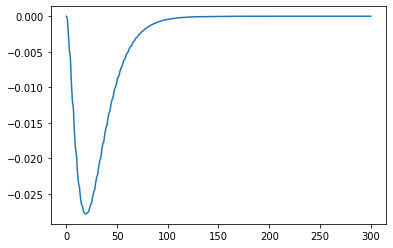

In [18]:
x = dsdp[:1505:5,0]
plt.plot(x)

In [ ]:
# define the uncertainty surrounding each of the parameters
# This is used for scaling the variables (i.e. 0.01 means that we are sure that the initial 
# value ofthat parameter is within 1 % of the real value)
param_uncertainties = {'k1':0.09,'k2':0.01,'k3':0.02,'k4':0.5}

# measurement scaling
meas_uncertainty = 0.05

In [ ]:
# The rank_params_yao function ranks parameters from most estimable to least estimable 
# using the method of Yao (2003). Notice the required arguments. Returns a dictionary of rankings.
listparams = e_analyzer.rank_params_yao(meas_scaling = meas_uncertainty, param_scaling = param_uncertainties, sigmas =sigmas)
print(listparams)

In [ ]:
# Now we can run the analyzer using the list of ranked parameters
params_to_select = e_analyzer.run_analyzer(method = 'Wu', parameter_rankings = listparams,meas_scaling = meas_uncertainty, variances =sigmas)
# We can then use this information to fix certain parameters and run the parameter estimation
print(params_to_select)

In [ ]:
dsdp, idx_to_param = e_analyzer.get_sensitivities_for_params(tee=True, sigmasq=sigmas)

In [ ]:
idx_to_param